In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn import GELU
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import bisect

In [2]:
# Step 1: Define the Neural Network Architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        return self.net(x)

In [3]:
# Step 2: Prepare the Data ---------------------------------------------------------------------

# ------------------------
# Load info
# ------------------------
info_df = pd.read_csv("info.csv")
fs = info_df.iloc[0, 5]                  # sampling frequency (Hz)

# ------------------------
# Load baseline data
# ------------------------
baseline_df = pd.read_csv("baselinedata.csv")
baseline_time = baseline_df.iloc[:, 0].values            # time column (seconds)
baseline_data = baseline_df.iloc[:, 1:].values           # data columns

# ------------------------
# Load main data
# ------------------------
df = pd.read_csv("data.csv")
time = df.iloc[:, 0].values            # time column (seconds)
data = df.iloc[:, 1:].values           # data columns

# ------------------------
# Load events
# ------------------------
events_df = pd.read_csv("events.csv")
event_times = events_df.iloc[:, 0].values  # assume first column is event time in seconds
event_times = np.sort(event_times)         # ensure sorted

# For fast lookup using binary search
def count_events_in_window(t, window=0.2):
    """
    Count how many event_times fall in (t - window, t].
    Uses bisect for O(log n) search.
    """
    left = bisect.bisect_right(event_times, t - window)
    right = bisect.bisect_right(event_times, t)
    return right - left

# ------------------------
# Compute event count for each row
# ------------------------
event_counts = np.array([count_events_in_window(t) for t in time])
event_counts = event_counts.reshape(-1, 1)

# Append event_counts as an additional input feature
data_aug = np.hstack([data, event_counts])
# Now each input row has: [original data..., event_count]

# ------------------------
# Build input-output pairs using the 3 ms rule
# ------------------------
dt_target = 0.003      # 3 ms
dt_tol = 0.0005        # ±0.5 ms
drow_target = int(dt_target * fs)  # number of rows corresponding to 3 ms

inputs = []
outputs = []

# --- baseline data ---
Nbl = len(baseline_df)
nbl = int(math.floor(.8 * Nbl))
baseline_data_aug = np.hstack([baseline_data, np.zeros((Nbl, 1))])
for i in range(nbl - drow_target):
    dt = baseline_time[i+drow_target] - baseline_time[i]
    if abs(dt - dt_target) <= dt_tol:
        inputs.append(baseline_data_aug[i])   # baseline input (zero event count)
        outputs.append(baseline_data[i+drow_target])    # output is ONLY the data (no event count)

# --- main data ---
N = len(df)
for i in range(N - drow_target):
    dt = time[i+drow_target] - time[i]
    if abs(dt - dt_target) <= dt_tol:
        inputs.append(data_aug[i])   # augmented input with event_count
        outputs.append(data[i+drow_target])    # output is ONLY the data (no event count)

# --- baseline data ---
for i in range(nbl, Nbl - drow_target):
    dt = baseline_time[i+drow_target] - baseline_time[i]
    if abs(dt - dt_target) <= dt_tol:
        inputs.append(baseline_data_aug[i])   # baseline input (zero event count)
        outputs.append(baseline_data[i+drow_target])    # output is ONLY the data (no event count)


X = torch.tensor(inputs, dtype=torch.float32)
Y = torch.tensor(outputs, dtype=torch.float32)

print("Pairs created:", len(X))
print("Input shape :", X.shape)   # features + 1
print("Output shape:", Y.shape)

# -----------------------------------------------------------------------------------------------


/var/folders/63/rd6zg9vd5v710s38rhy7y8jc0000gn/T/ipykernel_74248/3754538707.py:86: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  X = torch.tensor(inputs, dtype=torch.float32)


Pairs created: 1814991
Input shape : torch.Size([1814991, 101])
Output shape: torch.Size([1814991, 100])


In [4]:
# Step 3: Initialize the Model, Loss Function, and Optimizer
test_size=0.2
batch_size = 64
input_size = X.shape[1] # set input_size equal to the width of tensor X
output_size = Y.shape[1] # set output_size equal to the width of tensor Y
hidden_size = 128
model = NeuralNetwork(input_size, hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train / test
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size, random_state=42)
train_N = int((1 - test_size) * len(X))
X_train = X[:train_N]
Y_train = Y[:train_N]
X_test = X[train_N:]
Y_test = Y[train_N:]

# Create TensorDatasets
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size)

In [5]:
# data baseline characteristics as reference for loss 
mean_y = Y_train.mean(dim=0)
std_y = Y_train.std(dim=0)
var_y = std_y ** 2
var_per_feat = np.var(Y_train.numpy(), axis=0)  # redundant?

Train samples: 1451992
Batch size: 64
Batches/epoch: 22688
Epoch 1/100 — train_loss: 4.938333, val_loss: 39.311549
Epoch 2/100 — train_loss: 3.531916, val_loss: 10.574051
Epoch 3/100 — train_loss: 3.208612, val_loss: 12.498598
Epoch 4/100 — train_loss: 3.021692, val_loss: 15.770674
Epoch 5/100 — train_loss: 2.984358, val_loss: 8.937446
Epoch 6/100 — train_loss: 2.904648, val_loss: 10.171175
Epoch 7/100 — train_loss: 2.874114, val_loss: 9.731225
Epoch 8/100 — train_loss: 2.860651, val_loss: 9.181044
Epoch 9/100 — train_loss: 2.821036, val_loss: 10.712291
Epoch 10/100 — train_loss: 2.825105, val_loss: 8.254647
Epoch 11/100 — train_loss: 2.807206, val_loss: 10.293349
Epoch 12/100 — train_loss: 2.796176, val_loss: 12.797481
Epoch 13/100 — train_loss: 2.800109, val_loss: 8.397550
Epoch 14/100 — train_loss: 2.791068, val_loss: 8.996098
Epoch 15/100 — train_loss: 2.759780, val_loss: 9.455795
Epoch 16/100 — train_loss: 2.765831, val_loss: 8.259065
Epoch 17/100 — train_loss: 2.741254, val_loss:

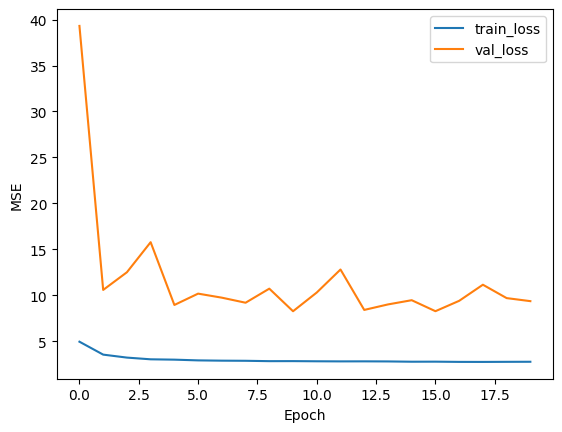

In [6]:
# Step 4: Train the Model
train_size = len(train_loader.dataset)
steps_per_epoch = math.ceil(train_size / batch_size)
print("Train samples:", train_size)
print("Batch size:", batch_size)
print("Batches/epoch:", steps_per_epoch)

model.train()
num_epochs = 100 # max
patience = 10
best_val = float('inf')
no_improve = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # --- train ---
    model.train()
    running_loss = 0.0
    for X_batch, Y_batch in train_loader:
        # Forward pass
        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_train_loss = running_loss / train_size
    train_losses.append(epoch_train_loss)

    # --- validate ---
    model.eval()
    val_running = 0.0
    with torch.no_grad():
        for X_val, Y_val in test_loader:   # use test_loader or a separate val_loader
            Y_val_pred = model(X_val)
            l = criterion(Y_val_pred, Y_val)
            val_running += l.item() * X_val.size(0)
    epoch_val_loss = val_running / len(test_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} — train_loss: {epoch_train_loss:.6f}, val_loss: {epoch_val_loss:.6f}")

    # --- Early stopping ---
    if epoch_val_loss < best_val - 1e-9:
        best_val = epoch_val_loss
        no_improve = 0
        # Optionally save best model:
        # torch.save(model.state_dict(), "best_model.pth")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"No improvement for {patience} epochs — stopping early at epoch {epoch+1}.")
            break

# After loop: plot train/val loss to inspect convergence
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

Test Loss: 9.3526


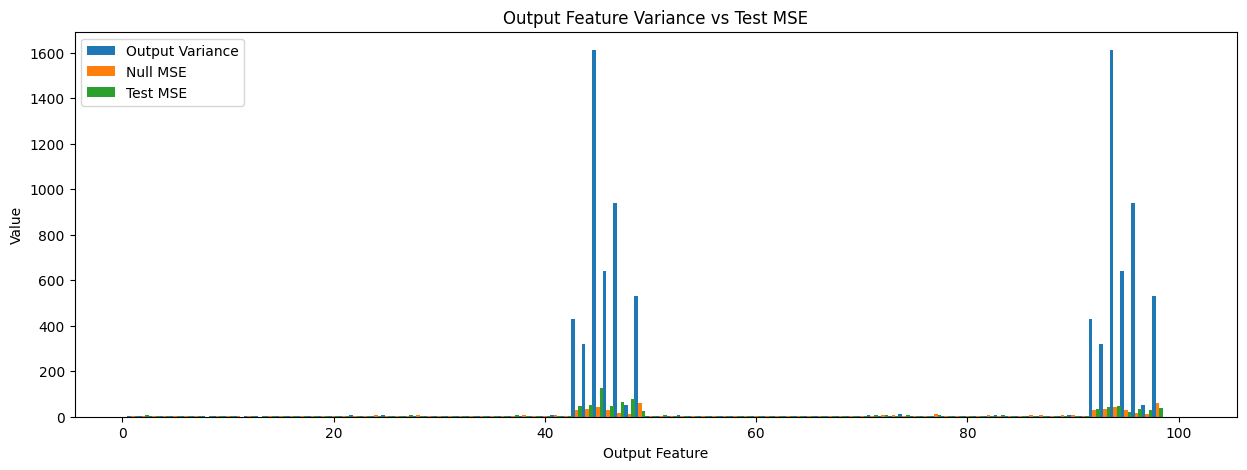

In [7]:
# Step 5: Evaluate the Model on Test Data
model.eval()
with torch.no_grad():
    total_loss = 0
    for X_batch, Y_batch in test_loader:
        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch)
        total_loss += loss.item() * X_batch.size(0)  # sum up batch loss

    avg_loss = total_loss / len(test_dataset)
    print(f"Test Loss: {avg_loss:.4f}")

Y_test_np = Y_test.numpy()
with torch.no_grad():
    Y_pred_np = model(X_test).numpy()

X_all_np = X.numpy()
Y_all_np = Y.numpy()
with torch.no_grad():
    Y_pred_all_np = model(X).numpy()

Y_null_all_np = X.numpy()[:, :Y.shape[1]]
Y_null_test_np = X_test.numpy()[:, :Y.shape[1]]

MSE_per_feat = np.mean((Y_test_np - Y_pred_np) ** 2, axis=0)
MSE_per_feat_null = np.mean((Y_test_np - Y_null_test_np) ** 2, axis=0)
feats = np.arange(1, Y.shape[1]+1)
barwid = .35

plt.figure(figsize=(15,5))
plt.bar(feats - barwid, var_per_feat, width=barwid, label='Output Variance')
plt.bar(feats, MSE_per_feat_null, width=barwid, label='Null MSE')
plt.bar(feats + barwid, MSE_per_feat, width=barwid, label='Test MSE')
plt.xlabel('Output Feature')
plt.ylabel('Value')
plt.title('Output Feature Variance vs Test MSE')
plt.legend()
plt.show()

In [8]:
# simulations 
simdur = int(0.2 * fs) # samples 
plotdomain = 1000 * np.array([-1, 1]) + train_N

Ysim = []
i0 = plotdomain[0]
model.eval()
while i0+simdur < plotdomain[1]:
    xi = torch.tensor(X_all_np[i0, :].reshape(1, -1), dtype=torch.float32)
    for i in range(simdur):
        with torch.no_grad():
            yi = model(xi).numpy().flatten()
        Ysim.append(yi)
        # prepare next input
        if i < simdur - 1:
            event_count_next = X_all_np[i0 + i + 1, -1]  # keep using original event count
            xi = torch.tensor(np.hstack([yi, event_count_next]).reshape(1, -1), dtype=torch.float32)
    i0 += simdur
    print("Simulating:", (i0-plotdomain[0])/(plotdomain[1]-plotdomain[0]), " complete." )

Ysim = np.array(Ysim)
plotxval = np.arange(len(Ysim)) + plotdomain[0]

Simulating: 0.1  complete.
Simulating: 0.2  complete.
Simulating: 0.3  complete.
Simulating: 0.4  complete.
Simulating: 0.5  complete.
Simulating: 0.6  complete.
Simulating: 0.7  complete.
Simulating: 0.8  complete.
Simulating: 0.9  complete.


/var/folders/63/rd6zg9vd5v710s38rhy7y8jc0000gn/T/ipykernel_74248/2621549880.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/torenarginteanu/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


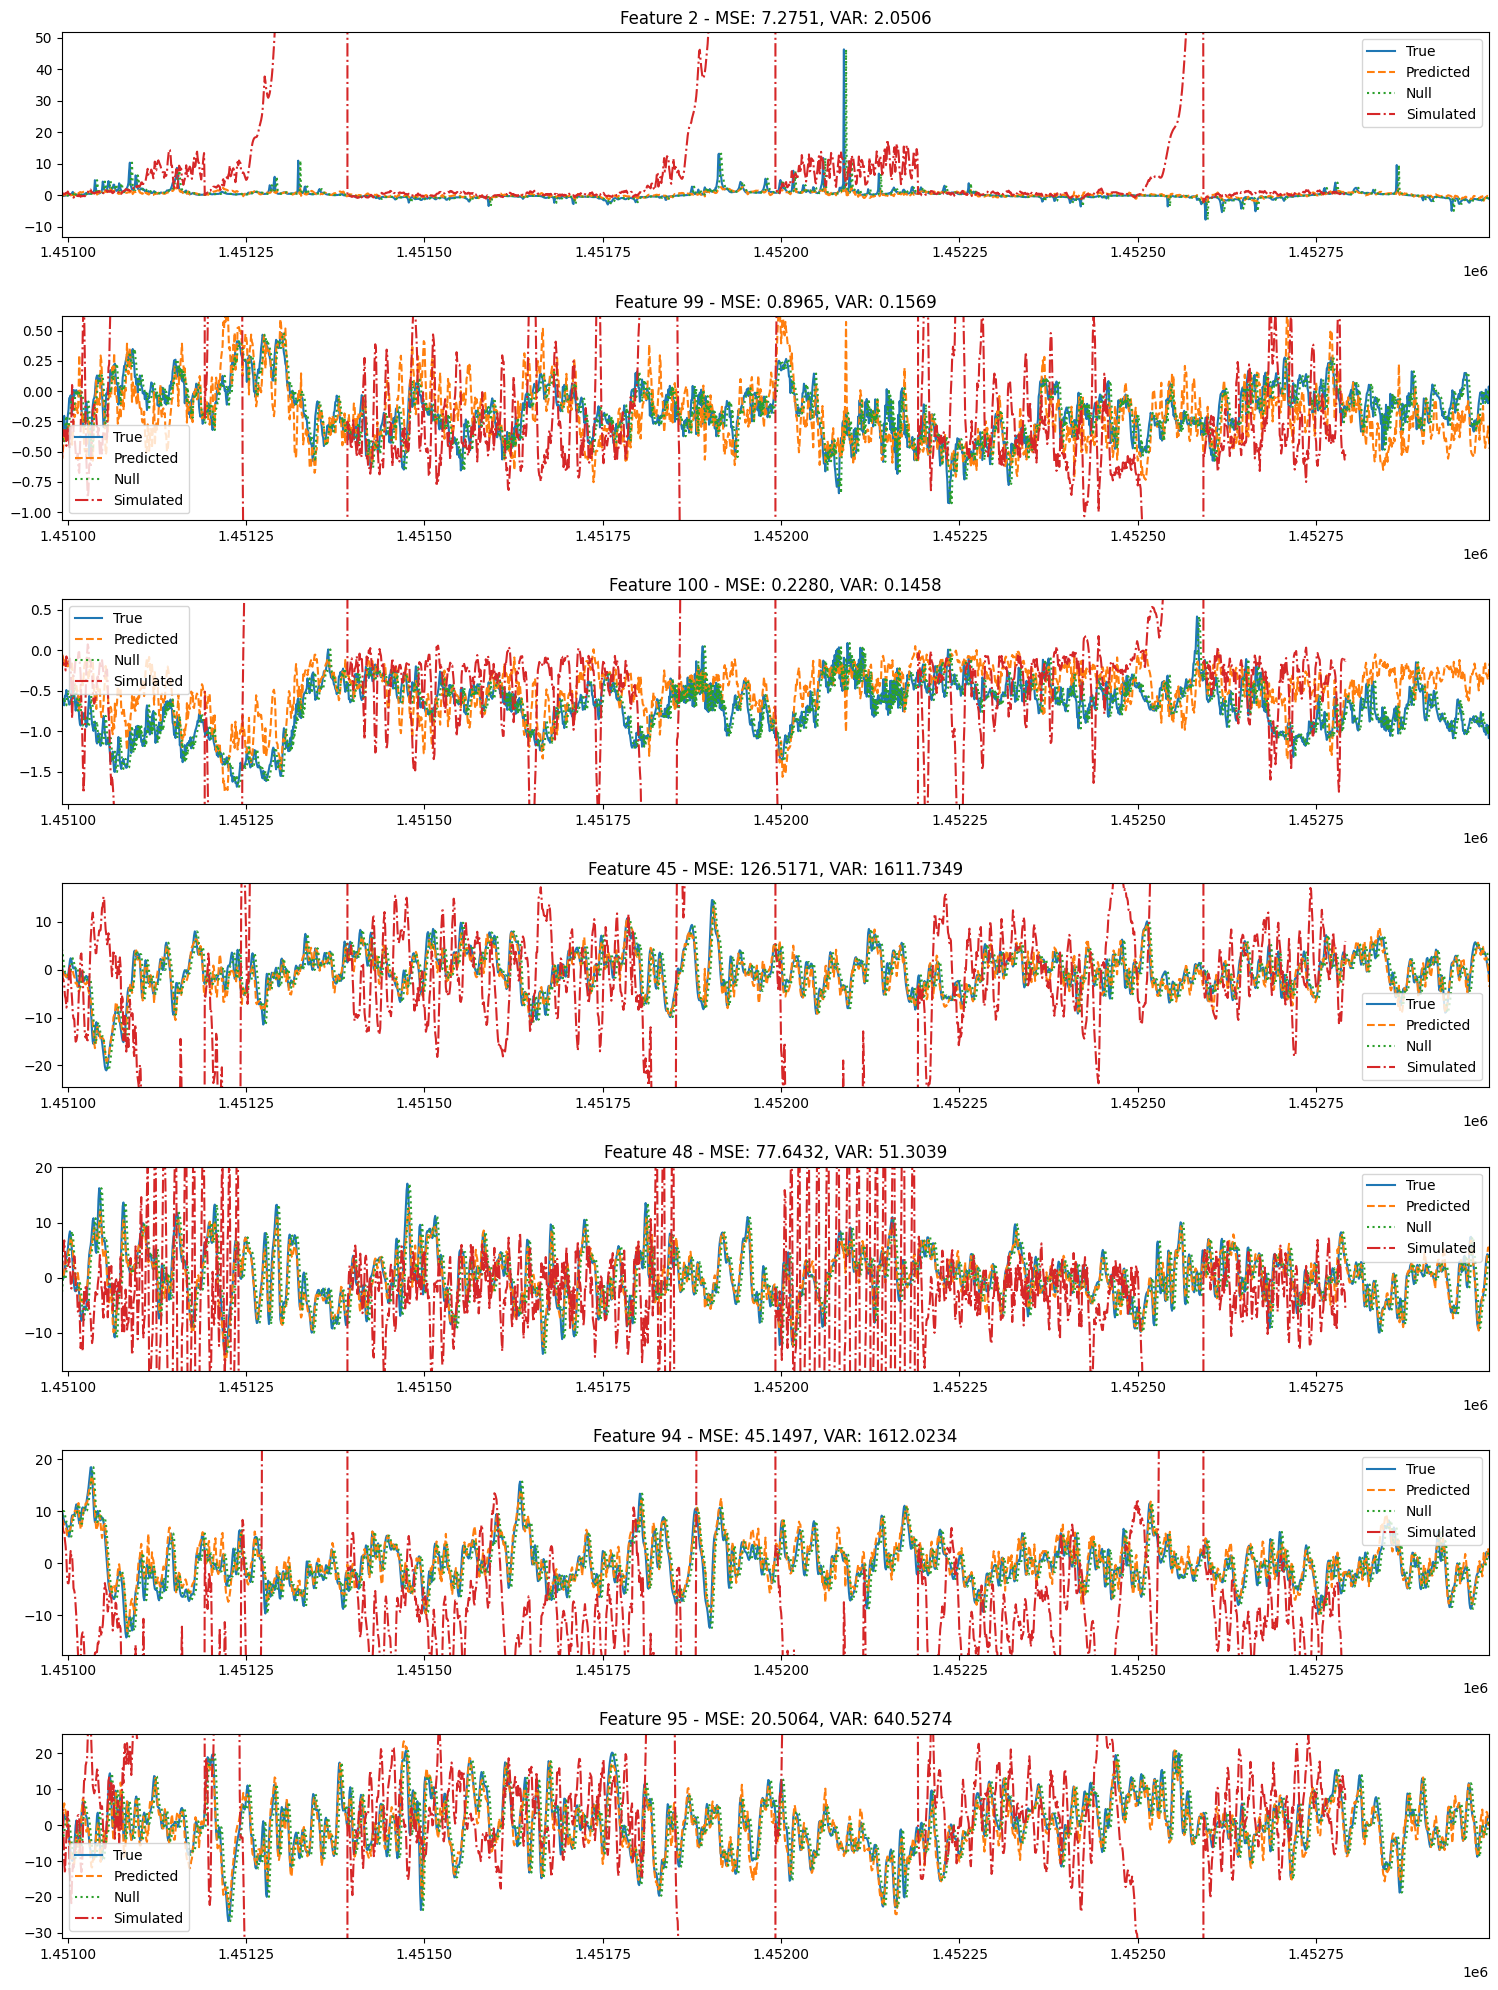

In [9]:
# show several examples 

iMSE = np.argsort(MSE_per_feat)
iVAR = np.argsort(var_per_feat)
iLRN = np.argsort(MSE_per_feat / var_per_feat)
iToPlot = [iMSE[:2], iMSE[-2:], iVAR[:2], iVAR[-2:], iLRN[:2], iLRN[-2:]]
iToPlot = list(set([i for sublist in iToPlot for i in sublist]))

plt.figure(figsize=(15,20))
iPlot = 1
for i in iToPlot:
    plt.subplot(len(iToPlot), 1, iPlot)
    plt.plot(Y_all_np[:, i], label='True')
    plt.plot(Y_pred_all_np[:, i], label='Predicted', linestyle='--')
    plt.plot(Y_null_all_np[:, i], label='Null', linestyle=':')
    plt.plot(plotxval, Ysim[:,i], label='Simulated', linestyle='-.')
    plt.xlim(plotdomain)

    # set the y limits to be slightly larger than the min/max of true values in the plotdomain
    y_min = np.min(Y_all_np[plotdomain[0]:plotdomain[1], i])
    y_max = np.max(Y_all_np[plotdomain[0]:plotdomain[1], i])
    y_range = y_max - y_min
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)
    
    plt.title(f'Feature {i+1} - MSE: {MSE_per_feat[i]:.4f}, VAR: {var_per_feat[i]:.4f}')
    plt.legend()
    iPlot += 1
plt.tight_layout()
plt.show()